# Service Control with Constraint - Average Reward

In [2]:
from scipy.stats import poisson

import pyomo.environ as pyo
from pyomo.opt import TerminationCondition
 
solver = "appsi_highs"
SOLVER = pyo.SolverFactory(solver)
SOLVER.options["time_limit"] = 60  # limit in seconds
model = pyo.ConcreteModel("Service Control LPT")

# period cost d(b) for using server state b for one period
d = {0:0, 1:2, 2:5}

# cost K for changing the service rate
K = 3

# reward R for processing 1 job per period
R = 5

# max system capacity
S_max = 8

# costs for using server state b_prime when previous 
# server state was b. These consists of a period cost of using 
# server state b_prime and a cost for changing server state if
# b_prime <> b.
def c(b, b_prime):
    if b_prime == b:
        return d[b_prime]
    else:
        return d[b_prime] + 3

def h(s):
    return 2 * s

# probability f_b(n) of processing n jobs if the service rate is b. 
def f(n, b):
    if b == 0:
        if n == 1:
            return 0.8
        elif n == 2:
            return 0.2
        else:
            return 0.0
        
    elif b == 1:
            if n == 1:
                return 0.5
            elif n == 2:
                return 0.5
            else:
                return 0.0
            
    elif b == 2:
            if n == 1:
                return 0.2
            elif n == 2:
                return 0.8
            else:
                return 0.0
    
    else:
        return 0.0


def range_zero_until(n):
    return range(n+1)

# probability g(n) of n new jobs arriving
def g(n):
    return poisson.pmf(n, mu=1.5)

# probability of n or more new jobs arriving
def g_or_more(n):
    return 1 - sum(g(m) for m in range_zero_until(n-1))

# s in S: number of jobs in the system 
model.S = pyo.Set(initialize=range_zero_until(S_max))

# b in B: server state
model.B = pyo.Set(initialize=[0,1,2])

# LP decision variable x_{(s,b),b'}: probability of choosing
# server state b' when state is (s,b) 
model.x = pyo.Var(
    model.S, model.B, model.B, bounds=(0, 1), domain=pyo.NonNegativeReals
)

# Expected reward R_{(s,b),a'} when state is (s,b) and choosen service rate is a'.
@model.Param(model.S, model.B, model.B)
def r(m, s, b, a):
    if s == 0:
        return 0.0 - c(b, a) 
    elif s == 1:
        return R * 1.0 - h(s) - c(b, a) 
    else:
        return R * sum(f(n, a) * n for n in [1,2]) - h(s) - c(b, a)

# Transition probabilities of moving from state (s_i, b_i) to (s_j, b_j)
# if choosen service rate is a
@model.Param(model.S, model.B, model.S, model.B, model.B)
def P(m, s_i, b_i, s_j, b_j, a):
    if b_j != a:
        return 0.0

    if s_i == 0:
        if s_j < S_max:
            return g(s_j)
        
        elif s_j == S_max:
            return g_or_more(s_j)
        
        else:
            return 0.0
        
    elif s_i == 1:
        if s_j < S_max:
            return g(s_j)
        
        elif s_j == S_max:
            return g_or_more(s_j)
        
        else:
            return 0.0
        
    elif s_i <= S_max:
        if s_j < S_max:
            return sum(f(n,b_j) * g(s_j - s_i + n) for n in [1, 2])
        
        elif s_j == S_max:
            return sum(f(n,b_j) * g_or_more(s_j - s_i + n) for n in [1, 2])
        
        else:
            return 0.0
        
    else:
        return 0.0
    

@model.Objective(sense=pyo.maximize)
def average_reward(m):
    return pyo.quicksum(
        m.r[s, b, a] * m.x[s, b, a]
        for s in m.S
        for b in m.B
        for a in m.B
    )

@model.Constraint(model.S, model.B)
def balance(m, s_j, b_j):
    return pyo.quicksum(
        m.P[s_i, b_i, s_j, b_j, a] * m.x[s_i, b_i, a]
        for s_i in m.S
        for b_i in m.B
        for a in m.B
    ) == pyo.quicksum(
        m.x[s_j, b_j, a]
        for a in m.B
    )

@model.Constraint()
def probabilities(m):
    return pyo.quicksum(
        m.x[s, b, a]
        for s in m.S
        for b in m.B
        for a in m.B
    ) == 1

@model.Constraint()
def service_rate_restriction(m):
    return pyo.quicksum(
        m.x[s, 2, a]
        for s in m.S
        for a in m.B
    ) <= 0.25

results = SOLVER.solve(model, load_solutions=False)

optimal_policy = {(s, b): {} for s in model.S for b in model.B}

if results.solver.termination_condition == TerminationCondition.optimal:
    model.solutions.load_from(results)

    for s in model.S:
        print(f"If {s} jobs in the system.")
        for b in model.B:
            print(f"   If previous service rate was {b}.")
            for a in model.B:
                x_opt = pyo.value(model.x[s, b, a])
                if x_opt > 0:
                    print(f"      Use service rate {a}.")
                    optimal_policy[(s, b)][a] = x_opt

else:
    print("No feasible solution found.")

If 0 jobs in the system.
   If previous service rate was 0.
      Use service rate 0.
   If previous service rate was 1.
      Use service rate 1.
   If previous service rate was 2.
If 1 jobs in the system.
   If previous service rate was 0.
      Use service rate 0.
   If previous service rate was 1.
      Use service rate 1.
   If previous service rate was 2.
      Use service rate 0.
If 2 jobs in the system.
   If previous service rate was 0.
      Use service rate 0.
   If previous service rate was 1.
      Use service rate 1.
   If previous service rate was 2.
      Use service rate 1.
If 3 jobs in the system.
   If previous service rate was 0.
      Use service rate 1.
   If previous service rate was 1.
      Use service rate 1.
   If previous service rate was 2.
      Use service rate 2.
If 4 jobs in the system.
   If previous service rate was 0.
      Use service rate 2.
   If previous service rate was 1.
      Use service rate 1.
   If previous service rate was 2.
      Use se

    Jobs_in_System(s)  Previous_Rate(b)  Chosen_Rate(a)  Probability
0                   0                 0               0     0.003885
1                   0                 1               1     0.049587
2                   1                 0               0     0.006894
3                   1                 1               1     0.102950
4                   1                 2               0     0.005440
5                   2                 0               0     0.005969
6                   2                 1               1     0.121977
7                   2                 2               1     0.017413
8                   3                 0               1     0.003384
9                   3                 1               1     0.113312
10                  3                 2               2     0.030476
11                  4                 0               2     0.001419
12                  4                 1               1     0.092481
13                  4             

    Jobs_in_System(s)  Previous_Rate(b)  Chosen_Rate(a)  Probability
0                   0                 0               0     0.003885
1                   0                 1               1     0.049587
2                   1                 0               0     0.006894
3                   1                 1               1     0.102950
4                   1                 2               0     0.005440
5                   2                 0               0     0.005969
6                   2                 1               1     0.121977
7                   2                 2               1     0.017413
8                   3                 0               1     0.003384
9                   3                 1               1     0.113312
10                  3                 2               2     0.030476
11                  4                 0               2     0.001419
12                  4                 1               1     0.092481
13                  4             

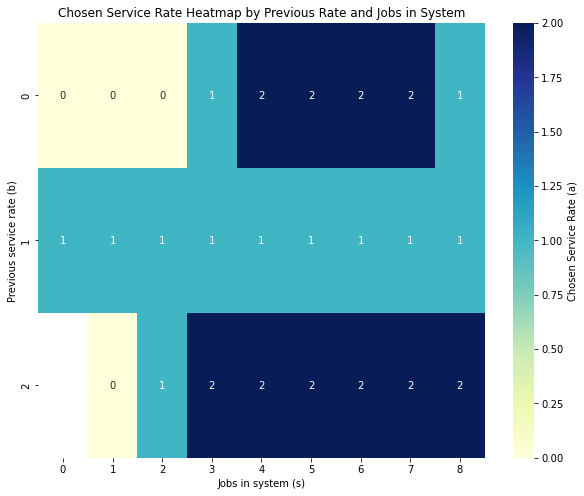

In [13]:
import pandas as pd
policy_df = pd.DataFrame([{'Jobs_in_System(s)': s, 'Previous_Rate(b)': b, 'Chosen_Rate(a)': a, 'Probability': prob}
            for (s, b), actions in optimal_policy.items()
            for a, prob in actions.items()])
print(policy_df)
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
policy_max_df = policy_df.loc[policy_df.groupby(['Jobs_in_System(s)', 'Previous_Rate(b)'])['Probability'].idxmax()]

heatmap_data = policy_max_df.pivot(columns = "Jobs_in_System(s)", index = "Previous_Rate(b)", values = "Chosen_Rate(a)")

# Plotting the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, annot=True, cmap="YlGnBu", cbar_kws={'label': 'Chosen Service Rate (a)'})
plt.title("Chosen Service Rate Heatmap by Previous Rate and Jobs in System")
plt.xlabel("Jobs in system (s)")
plt.ylabel("Previous service rate (b)")
plt.savefig("constraint.png", dpi=300, bbox_inches="tight", format="png")

plt.show()